# 1 IMDb Data Processing Overview
- Data source: auto-detect `data/aclImdb` or the mistyped `data/acllmdb`, reading `train/pos` and `train/neg` (we do not use the official `test` directory directly).
- Data split: split the official training set into our own `train/val/test` with 80/10/10, stratified, and fixed seed `SEED=42`.
- Text cleaning:
  - Remove HTML tags (`<...>`);
  - Normalize URLs to a placeholder (`http`);
  - Remove newlines and lowercase.
- Tokenization strategy: use regex `TOKEN_RE = [a-zA-Z']+` to extract English words (no stopword removal or lemmatization; simple baseline).
- Vocabulary:
  - Built only from the training set;
  - Minimum frequency `min_freq=2`;
  - Special tokens: `<pad>`=0, `<unk>`=1;
  - Other words are added sorted by frequency (desc) then alphabetically (asc) for stability.
- Numericalization: map tokens to word IDs; OOV tokens map to `<unk>`.
- Sequence length and truncation/padding:
  - Based on training length distribution, set `MAX_LEN = min(256, max(16, p95))`;
  - Right-pad to `MAX_LEN`; truncate longer sequences.
- Outputs (under `data/processed/`):
  - `vocab.json`: contains `word2idx` and `idx2word`;
  - `aclImdb_prepared.npz`: contains padded `X_train/X_val/X_test`, `y_*`, and `max_len/pad_idx/unk_idx`;
  - `meta.json`: contains `vocab_size`, `max_len`, split sizes, and `min_freq`.
- Note: The subsequent LSTM baseline directly uses the NPZ and vocab above. For a fully independent evaluation, apply the same preprocessing to the official `test/pos` and `test/neg`.

In [22]:
# 基础依赖导入
import os
import re
import json
from pathlib import Path
from collections import Counter
from typing import List, Tuple

import numpy as np
from sklearn.model_selection import train_test_split

SEED = 42
np.random.seed(SEED)

print('Environment ready. NumPy:', np.__version__)

Environment ready. NumPy: 2.2.6


In [23]:
# 数据路径自动探测
base_candidates = [Path('./data/aclImdb'), Path('./data/acllmdb')]
base_dir = None
for p in base_candidates:
    if p.exists():
        base_dir = p
        break

assert base_dir is not None, 'Dataset directory not found: please ensure data/aclImdb or data/acllmdb exists'
print('Using dataset dir:', base_dir)

train_pos = base_dir / 'train' / 'pos'
train_neg = base_dir / 'train' / 'neg'

for d in [train_pos, train_neg]:
    assert d.exists(), f'Missing directory: {d}'
print('Found train/pos and train/neg.')

Using dataset dir: data/aclImdb
Found train/pos and train/neg.


In [24]:
# 读取训练集原始评论
def load_reviews(dir_path: Path, label: int) -> Tuple[List[str], List[int]]:
    texts, labels = [], []
    for fp in sorted(dir_path.glob('*.txt')):
        try:
            text = fp.read_text(encoding='utf-8', errors='ignore')
        except Exception:
            text = fp.read_text(errors='ignore')
        texts.append(text)
        labels.append(label)
    return texts, labels

pos_texts, pos_labels = load_reviews(train_pos, 1)
neg_texts, neg_labels = load_reviews(train_neg, 0)

X_all = pos_texts + neg_texts
y_all = pos_labels + neg_labels

print(f'Total samples: {len(X_all)} | pos: {len(pos_texts)} | neg: {len(neg_texts)}')

Total samples: 25000 | pos: 12500 | neg: 12500


In [25]:
# 划分 train/val/test （从官方训练集内部按 80/10/10 拆分）
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.2, random_state=SEED, stratify=y_all
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

print(f'Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}')
# 注意：此处的 Test 是我们自定义的内部测试集，不是官方提供的 /test 目录
# 你也可以后续再用官方 test/pos & test/neg 作为额外独立评估集。

Train: 20000, Val: 2500, Test: 2500


In [26]:
# 文本清洗与分词
TAG_RE = re.compile(r'<[^>]+>')
URL_RE = re.compile(r'https?://\S+|www\.\S+')

def clean_text(s: str) -> str:
    s = TAG_RE.sub(' ', s)            # 移除HTML标签
    s = URL_RE.sub(' http ', s)       # URL归一化
    s = s.replace('\n', ' ')
    s = s.lower()
    return s

TOKEN_RE = re.compile(r"[a-zA-Z']+")

def tokenize(s: str) -> List[str]:
    return TOKEN_RE.findall(s)

# 简单自测
_ex = "I LOVED it! <br /><br />Visit https://example.com NOW."
print(tokenize(clean_text(_ex))[:10])

['i', 'loved', 'it', 'visit', 'http', 'now']


In [27]:
# 基于训练集构建词表
MIN_FREQ = 2
SPECIALS = ['<pad>', '<unk>']
PAD, UNK = 0, 1

def build_vocab(texts: List[str], min_freq: int = 2):
    counter = Counter()
    for t in texts:
        toks = tokenize(clean_text(t))
        counter.update(toks)
    # 频次阈值过滤 + 频次降序、词典序升序保证稳定性
    words = [w for w, c in counter.items() if c >= min_freq]
    words.sort(key=lambda w: (-counter[w], w))
    word2idx = {w: i for i, w in enumerate(SPECIALS)}
    for w in words:
        if w not in word2idx:
            word2idx[w] = len(word2idx)
    idx2word = [None] * len(word2idx)
    for w, i in word2idx.items():
        idx2word[i] = w
    return word2idx, idx2word, counter

word2idx, idx2word, counter = build_vocab(X_train, MIN_FREQ)
print('Vocab size:', len(word2idx))
print('Top-10 words:', list(counter.most_common(10)))

Vocab size: 46292
Top-10 words: [('the', 269333), ('and', 131160), ('a', 130207), ('of', 116864), ('to', 108226), ('is', 85846), ('in', 75262), ('it', 63387), ('i', 61570), ('this', 60724)]


In [28]:
# 数值化序列 + 长度统计
def to_ids(text: str, w2i: dict) -> List[int]:
    toks = tokenize(clean_text(text))
    return [w2i.get(tok, UNK) for tok in toks]

train_ids = [to_ids(t, word2idx) for t in X_train]
val_ids   = [to_ids(t, word2idx) for t in X_val]
test_ids  = [to_ids(t, word2idx) for t in X_test]

train_lens = np.array([len(x) for x in train_ids])
print('Train length stats -> min:', int(train_lens.min()), 'p50:', int(np.percentile(train_lens,50)),
      'p95:', int(np.percentile(train_lens,95)), 'max:', int(train_lens.max()))

Train length stats -> min: 10 p50: 173 p95: 597 max: 1830


In [29]:
# 选择padding的最大长度（以训练集95分位为基准，且上限256）
p95 = int(np.percentile([len(x) for x in train_ids], 95))
MAX_LEN = min(256, max(16, p95))
print('MAX_LEN =', MAX_LEN)

def pad_sequence(seq: List[int], max_len: int, pad_idx: int = PAD) -> List[int]:
    if len(seq) >= max_len:
        return seq[:max_len]
    return seq + [pad_idx] * (max_len - len(seq))

X_train_pad = np.array([pad_sequence(s, MAX_LEN) for s in train_ids], dtype=np.int32)
X_val_pad   = np.array([pad_sequence(s, MAX_LEN) for s in val_ids], dtype=np.int32)
X_test_pad  = np.array([pad_sequence(s, MAX_LEN) for s in test_ids], dtype=np.int32)
y_train_a   = np.array(y_train, dtype=np.int64)
y_val_a     = np.array(y_val, dtype=np.int64)
y_test_a    = np.array(y_test, dtype=np.int64)

print('Shapes ->',
      'X_train', X_train_pad.shape, 'X_val', X_val_pad.shape, 'X_test', X_test_pad.shape)

MAX_LEN = 256
Shapes -> X_train (20000, 256) X_val (2500, 256) X_test (2500, 256)
Shapes -> X_train (20000, 256) X_val (2500, 256) X_test (2500, 256)


In [30]:
# OOV与截断分析
import numpy as np

def _oov_rate(id_seqs, unk_idx):
    total = sum(len(s) for s in id_seqs)
    if total == 0:
        return 0.0
    oov = sum(int(t == unk_idx) for s in id_seqs for t in s)
    return oov / total

def _trunc_rate(raw_seqs, max_len):
    n = len(raw_seqs)
    if n == 0:
        return 0.0
    truncated = sum(1 for s in raw_seqs if len(s) > max_len)
    return truncated / n

train_oov = _oov_rate(train_ids, UNK)
val_oov   = _oov_rate(val_ids,   UNK)
test_oov  = _oov_rate(test_ids,  UNK)

train_trunc = _trunc_rate(train_ids, MAX_LEN)
val_trunc   = _trunc_rate(val_ids,   MAX_LEN)
test_trunc  = _trunc_rate(test_ids,  MAX_LEN)

print(f'OOV rate -> train: {train_oov:.4f}, val: {val_oov:.4f}, test: {test_oov:.4f}')
print(f'Truncation -> train: {train_trunc:.4f}, val: {val_trunc:.4f}, test: {test_trunc:.4f}')

# 估算平均padding占比（基于未截断长度）
train_avg_len = np.mean([min(len(s), MAX_LEN) for s in train_ids])
val_avg_len   = np.mean([min(len(s), MAX_LEN) for s in val_ids])
test_avg_len  = np.mean([min(len(s), MAX_LEN) for s in test_ids])
print(f'Avg effective len -> train: {train_avg_len:.1f}, val: {val_avg_len:.1f}, test: {test_avg_len:.1f} / MAX_LEN={MAX_LEN}')


OOV rate -> train: 0.0067, val: 0.0121, test: 0.0127
Truncation -> train: 0.2882, val: 0.2868, test: 0.2936
Avg effective len -> train: 178.1, val: 176.8, test: 180.7 / MAX_LEN=256


In [31]:
# 导出处理产物：词表与向量化数据
out_dir = Path('data/processed')
out_dir.mkdir(parents=True, exist_ok=True)

vocab_path = out_dir / 'vocab.json'
with vocab_path.open('w', encoding='utf-8') as f:
    json.dump({'word2idx': word2idx, 'idx2word': idx2word}, f, ensure_ascii=False)

npz_path = out_dir / 'aclImdb_prepared.npz'
np.savez_compressed(
    npz_path,
    X_train=X_train_pad, y_train=y_train_a,
    X_val=X_val_pad, y_val=y_val_a,
    X_test=X_test_pad, y_test=y_test_a,
    max_len=np.array([MAX_LEN], dtype=np.int32),
    pad_idx=np.array([PAD], dtype=np.int32),
    unk_idx=np.array([UNK], dtype=np.int32)
)

meta = {
    'min_freq': MIN_FREQ,
    'vocab_size': len(word2idx),
    'max_len': int(MAX_LEN),
    'splits': {
        'train': int(len(X_train_pad)),
        'val': int(len(X_val_pad)),
        'test': int(len(X_test_pad))
    }
}
with (out_dir / 'meta.json').open('w', encoding='utf-8') as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print('Saved ->', vocab_path, npz_path, out_dir / 'meta.json')
print('Done.')

Saved -> data/processed/vocab.json data/processed/aclImdb_prepared.npz data/processed/meta.json
Done.


# 2 Simple LSTM: DataLoader and Training

This section builds a lightweight PyTorch LSTM binary classifier on top of the arrays produced above (`X_train_pad/X_val_pad/X_test_pad`, etc.).

If you have not run the preprocessing cells, this section will attempt to load from `data/processed/aclImdb_prepared.npz` and `vocab.json`. 

In [32]:
# 简单LSTM：导入与数据加载（内存/文件）
import os
import json
import numpy as np
from pathlib import Path

import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Prefer deterministic error locations for CUDA issues
os.environ.setdefault("CUDA_LAUNCH_BLOCKING", "1")
os.environ.setdefault("CUDA_VISIBLE_DEVICES", "1")
# Robust device selection
print(f"torch.cuda.is_available():{torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
try:
    _ = torch.randn(1, device=device)
except Exception as e:
    print('CUDA seems unhealthy, falling back to CPU. Error:', e)
    device = torch.device('cpu')
print('Device:', device)

# 全量设定随机种子，确保可复现
try:
    _SEED = SEED
except NameError:
    _SEED = 42
random.seed(_SEED)
np.random.seed(_SEED)
torch.manual_seed(_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(_SEED)
# 为了结果可重复，禁用cudnn自动优化
try:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except Exception:
    pass

# 如果前面单元未运行，尝试从已保存文件加载
def _arrays_in_memory():
    try:
        _ = X_train_pad, X_val_pad, X_test_pad, y_train_a, y_val_a, y_test_a, word2idx, PAD, UNK, MAX_LEN
        return True
    except NameError:
        return False

if not _arrays_in_memory():
    npz_path = Path('data/processed/aclImdb_prepared.npz')
    vocab_path = Path('data/processed/vocab.json')
    assert npz_path.exists(), f'Missing {npz_path}. Please run the preprocessing cells to generate it first.'
    with np.load(npz_path) as npz:
        X_train_pad = npz['X_train']; y_train_a = npz['y_train']
        X_val_pad   = npz['X_val'];   y_val_a   = npz['y_val']
        X_test_pad  = npz['X_test'];  y_test_a  = npz['y_test']
        MAX_LEN = int(npz['max_len'][0])
        PAD     = int(npz['pad_idx'][0])
        UNK     = int(npz['unk_idx'][0])
    with open(vocab_path, 'r', encoding='utf-8') as f:
        word2idx = json.load(f)['word2idx']

vocab_size = len(word2idx)
pad_idx = PAD
print('Loaded arrays. vocab_size =', vocab_size, 'max_len =', MAX_LEN)

print("X_train_pad max:", X_train_pad.max(), "min:", X_train_pad.min())
print("vocab_size:", vocab_size)


torch.cuda.is_available():True
Device: cuda
Loaded arrays. vocab_size = 46292 max_len = 256
X_train_pad max: 46291 min: 0
vocab_size: 46292


In [33]:
# 构建 Dataset 与 DataLoader
class NpArrayDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.as_tensor(X, dtype=torch.long)
        self.y = torch.as_tensor(y, dtype=torch.float32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_ds = NpArrayDataset(X_train_pad, y_train_a)
val_ds   = NpArrayDataset(X_val_pad, y_val_a)
test_ds  = NpArrayDataset(X_test_pad, y_test_a)

# DataLoader 进一步强化：worker种子、持久worker、预取
_num_workers = 2
_pin = (device.type=='cuda')

def _seed_worker(worker_id):
    base_seed = (_SEED if '_SEED' in globals() else 42)
    rng = np.random.RandomState(base_seed + worker_id)
    random.seed(rng.randint(0, 2**31-1))
    np.random.seed(rng.randint(0, 2**31-1))
    torch.manual_seed(rng.randint(0, 2**31-1))

common_kwargs = dict(num_workers=_num_workers, pin_memory=_pin)
if _num_workers and _num_workers > 0:
    common_kwargs.update(dict(persistent_workers=True, prefetch_factor=4, worker_init_fn=_seed_worker))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  **common_kwargs)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, **common_kwargs)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, **common_kwargs)

len(train_ds), len(val_ds), len(test_ds)

(20000, 2500, 2500)

In [34]:
# Sanity check: ensure token IDs are within vocab range and non-negative
import numpy as np
def _check_ids(name, arr, vocab_size):
    mn = int(np.min(arr))
    mx = int(np.max(arr))
    print(f'{name}: min={mn}, max={mx}, vocab_size={vocab_size}')
    assert mn >= 0, f'{name} contains negative token ids: {mn}'
    assert mx < vocab_size, f'{name} contains out-of-vocab ids: max {mx} >= vocab_size {vocab_size}'

_check_ids('X_train_pad', X_train_pad, vocab_size)
_check_ids('X_val_pad',   X_val_pad,   vocab_size)
_check_ids('X_test_pad',  X_test_pad,  vocab_size)

X_train_pad: min=0, max=46291, vocab_size=46292
X_val_pad: min=0, max=46281, vocab_size=46292
X_test_pad: min=0, max=46270, vocab_size=46292


In [35]:
# 定义LSTM模型与优化器
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=128, num_layers=1, bidirectional=False, pad_idx=0, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout if num_layers>1 else 0.0)
        out_dim = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Linear(out_dim, 1)
    def forward(self, x):
        emb = self.embedding(x)
        out, (h_n, c_n) = self.lstm(emb)
        if self.lstm.bidirectional:
            last = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            last = h_n[-1]
        logits = self.fc(last).squeeze(1)
        return logits

model = LSTMClassifier(vocab_size=vocab_size, embed_dim=100, hidden_dim=128, num_layers=1, bidirectional=False, pad_idx=pad_idx).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print(model)

LSTMClassifier(
  (embedding): Embedding(46292, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [36]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 训练与验证循环（记录历史以便绘图）
def binary_acc(logits, targets):
    preds = (torch.sigmoid(logits) >= 0.5).float()
    return (preds == targets).float().mean().item()

epochs = 3
best_val_loss = float('inf')
lstm_train_loss_hist, lstm_val_loss_hist = [], []
lstm_train_acc_hist, lstm_val_acc_hist = [], []

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    n = 0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        bs = y.size(0)
        total_loss += loss.item() * bs
        total_acc += binary_acc(logits.detach(), y) * bs
        n += bs
    train_loss = total_loss / n
    train_acc = total_acc / n
    lstm_train_loss_hist.append(train_loss)
    lstm_train_acc_hist.append(train_acc)

    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        total_acc = 0.0
        n = 0
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)
            logits = model(X)
            loss = criterion(logits, y)
            bs = y.size(0)
            total_loss += loss.item() * bs
            total_acc += binary_acc(logits, y) * bs
            n += bs
        val_loss = total_loss / n
        val_acc = total_acc / n
        lstm_val_loss_hist.append(val_loss)
        lstm_val_acc_hist.append(val_acc)
    print(f'Epoch {epoch}: train_loss={train_loss:.4f} acc={train_acc:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f}')

Epoch 1: train_loss=0.6929 acc=0.5067 | val_loss=0.6912 acc=0.5200
Epoch 2: train_loss=0.6840 acc=0.5638 | val_loss=0.6837 acc=0.5688
Epoch 2: train_loss=0.6840 acc=0.5638 | val_loss=0.6837 acc=0.5688
Epoch 3: train_loss=0.6586 acc=0.6189 | val_loss=0.6672 acc=0.6192
Epoch 3: train_loss=0.6586 acc=0.6189 | val_loss=0.6672 acc=0.6192


In [37]:
# 测试集评估
model.eval()
with torch.no_grad():
    total_acc = 0.0
    n = 0
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        logits = model(X)
        total_acc += (torch.sigmoid(logits).round() == y).float().sum().item()
        n += y.size(0)
    test_acc = total_acc / n
print('Test accuracy:', round(test_acc, 4))

Test accuracy: 0.5932


# 3 Fine-tuning a Pretrained LM (BERT/DistilBERT): Overview
- Goal: fine-tune a large pretrained LM (e.g., `distilbert-base-uncased`) for IMDb binary classification.
- Method: Hugging Face `transformers` + `datasets`, dynamic padding, train and evaluate with `Trainer`.
- Data: prefer using in-memory `X_train/X_val/X_test` raw texts; otherwise rebuild splits from `data/aclImdb` with the same seed.
- Evaluation: report validation/test accuracy and optional F1.
- Resources: automatically uses GPU if available; FP16 is supported with a proper CUDA setup.

In [38]:
import numpy as np
import torch
from datasets import Dataset
import evaluate
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments, set_seed)
print('transformers/datasets ready. torch cuda:', torch.cuda.is_available())

# 统一设置训练随机种子
try:
    _SEED = SEED
except NameError:
    _SEED = 42
set_seed(_SEED)

transformers/datasets ready. torch cuda: True


In [39]:
# 数据准备：优先使用内存中的原始文本，否则按相同流程重建
from pathlib import Path
from sklearn.model_selection import train_test_split
import re
import json as _json

def _has_raw_splits():
    try:
        _ = X_train, X_val, X_test, y_train, y_val, y_test
        return True
    except NameError:
        return False

if not _has_raw_splits():
    # 从原始目录重读，并用相同SEED与比例重建split
    base_candidates = [Path('./data/aclImdb'), Path('./data/acllmdb')]
    base_dir = None
    for p in base_candidates:
        if p.exists():
            base_dir = p; break
    assert base_dir is not None, 'Dataset directory not found: data/aclImdb or data/acllmdb'
    def load_reviews(dir_path: Path, label: int):
        texts, labels = [], []
        for fp in sorted(dir_path.glob('*.txt')):
            try: t = fp.read_text(encoding='utf-8', errors='ignore')
            except Exception: t = fp.read_text(errors='ignore')
            texts.append(t); labels.append(label)
        return texts, labels
    pos_texts, pos_labels = load_reviews(base_dir/'train'/'pos', 1)
    neg_texts, neg_labels = load_reviews(base_dir/'train'/'neg', 0)
    X_all = pos_texts + neg_texts
    y_all = pos_labels + neg_labels
    SEED = 42
    X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.2, random_state=SEED, stratify=y_all)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

print('Raw splits ready. Train/Val/Test =', len(X_train), len(X_val), len(X_test))

# 构造HF Datasets
train_ds = Dataset.from_dict({'text': X_train, 'label': y_train})
val_ds   = Dataset.from_dict({'text': X_val,   'label': y_val})
test_ds  = Dataset.from_dict({'text': X_test,  'label': y_test})
train_ds, val_ds, test_ds

Raw splits ready. Train/Val/Test = 20000 2500 2500


(Dataset({
     features: ['text', 'label'],
     num_rows: 20000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 2500
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 2500
 }))

In [40]:
# 分词映射：使用DistilBERT分词器并进行动态padding
import os
MODEL_NAME = 'distilbert-base-uncased'  # 也可换成 bert-base-uncased
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tok_fn(batch):
    return tokenizer(batch['text'], truncation=True, max_length=256)

# 并行tokenize，并缓存到Arrow（datasets默认缓存）
num_proc = max(1, os.cpu_count() or 1)
train_tok = train_ds.map(tok_fn, batched=True, remove_columns=['text'], num_proc=num_proc)
val_tok   = val_ds.map(tok_fn,   batched=True, remove_columns=['text'], num_proc=num_proc)
test_tok  = test_ds.map(tok_fn,  batched=True, remove_columns=['text'], num_proc=num_proc)

collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_tok, val_tok, test_tok

Map (num_proc=128): 100%|██████████| 2500/2500 [00:03<00:00, 791.34 examples/s] 



(Dataset({
     features: ['label', 'input_ids', 'attention_mask'],
     num_rows: 20000
 }),
 Dataset({
     features: ['label', 'input_ids', 'attention_mask'],
     num_rows: 2500
 }),
 Dataset({
     features: ['label', 'input_ids', 'attention_mask'],
     num_rows: 2500
 }))

In [41]:
# 模型与Trainer配置
from sklearn.metrics import accuracy_score, f1_score
metric_accuracy = evaluate.load('accuracy')
metric_f1 = evaluate.load('f1')

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

bsz = 16
args = TrainingArguments(
    output_dir='models/distilbert-imdb',
    num_train_epochs=2,
    per_device_train_batch_size=bsz,
    per_device_eval_batch_size=bsz*2,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    report_to='none',
    # 性能与稳定性
    group_by_length=True,
    dataloader_num_workers=2,
    seed=_SEED,
    data_seed=_SEED,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics
)
trainer

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3699276/1446230710.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.17, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/tmp/ipykernel_3699276/1446230710.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.17, which is below the recommended m

In [42]:
# 训练与评估（验证+测试）
train_result = trainer.train()
metrics_val = trainer.evaluate(eval_dataset=val_tok)
print('Val metrics:', metrics_val)

# 测试集评估
test_metrics = trainer.evaluate(eval_dataset=test_tok)
print('Test metrics:', test_metrics)

# 保存最佳模型与分词器
trainer.save_model('models/distilbert-imdb/best')
tokenizer.save_pretrained('models/distilbert-imdb/best')

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.267700,0.298213,0.905200,0.904397
2,0.156700,0.305950,0.917200,0.917034


Val metrics: {'eval_loss': 0.30596035718917847, 'eval_accuracy': 0.9172, 'eval_f1': 0.9170340681362725, 'eval_runtime': 0.8649, 'eval_samples_per_second': 2890.361, 'eval_steps_per_second': 91.335, 'epoch': 2.0}
Test metrics: {'eval_loss': 0.32659685611724854, 'eval_accuracy': 0.9044, 'eval_f1': 0.9044382247101159, 'eval_runtime': 0.9068, 'eval_samples_per_second': 2757.021, 'eval_steps_per_second': 87.122, 'epoch': 2.0}
Test metrics: {'eval_loss': 0.32659685611724854, 'eval_accuracy': 0.9044, 'eval_f1': 0.9044382247101159, 'eval_runtime': 0.9068, 'eval_samples_per_second': 2757.021, 'eval_steps_per_second': 87.122, 'epoch': 2.0}


('models/distilbert-imdb/best/tokenizer_config.json',
 'models/distilbert-imdb/best/special_tokens_map.json',
 'models/distilbert-imdb/best/vocab.txt',
 'models/distilbert-imdb/best/added_tokens.json',
 'models/distilbert-imdb/best/tokenizer.json')

# 4 BERT vs LSTM: Performance, Compute, and Complexity Trade-offs
- Performance:
  - Pretrained models (DistilBERT/BERT) typically outperform from-scratch LSTM baselines on IMDb, especially with limited data or complex linguistic phenomena;
  - Self-attention models long-range dependencies, converging faster with higher val/test accuracy (often >90%).
- Compute cost:
  - Larger parameter counts, higher VRAM usage, and generally higher inference latency than small LSTMs;
  - Best with GPU; FP16/AMP recommended. Training on CPU is slow.
- Implementation complexity:
  - `transformers` Trainer simplifies code, but the dependency stack is heavier (weights download, tokenizer, data collator, accelerator config, etc.);
  - LSTM baselines are lighter, fully customizable, and great for teaching/rapid prototyping.
- When to choose:
  - Need higher accuracy/robustness and have GPU resources → choose BERT-family;
  - Resource-constrained, latency-sensitive, or need fully controllable lightweight models → choose LSTM/conv-based baselines.

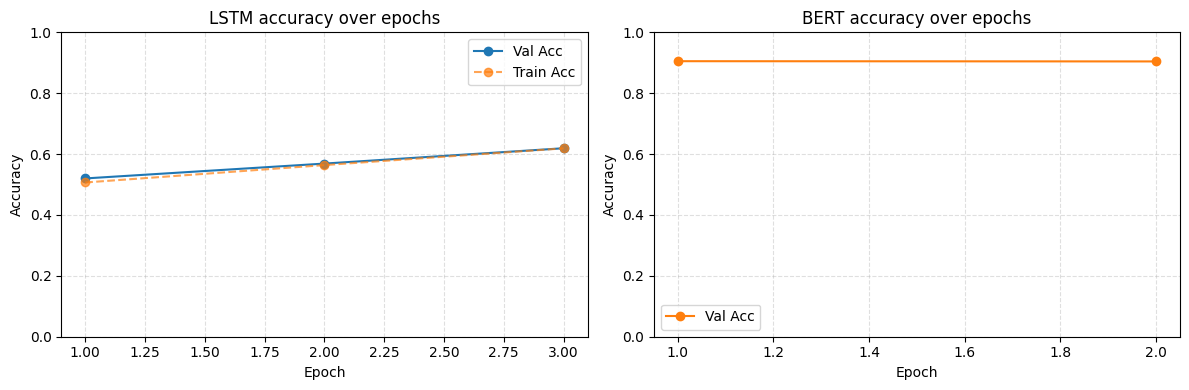

In [43]:
# 精度变化曲线：LSTM 与 BERT
# Prepare LSTM validation accuracy
import matplotlib.pyplot as plt

lstm_epochs = None
if 'lstm_val_acc_hist' in globals() and isinstance(lstm_val_acc_hist, list) and len(lstm_val_acc_hist) > 0:
    lstm_epochs = list(range(1, len(lstm_val_acc_hist)+1))

# Prepare BERT validation accuracy (from Trainer log_history: eval_accuracy)
bert_epochs, bert_val_acc = [], []
if 'trainer' in globals():
    try:
        logs = getattr(trainer.state, 'log_history', [])
        tmp = []
        for rec in logs:
            if isinstance(rec, dict) and 'eval_accuracy' in rec:
                ep = rec.get('epoch', None)
                try: ep = int(ep) if ep is not None else None
                except Exception: ep = None
                tmp.append((ep, rec['eval_accuracy']))
        # If epoch is missing, use sequential indices
        if all(ep is None for ep, _ in tmp):
            for i, (_, acc) in enumerate(tmp, start=1):
                bert_epochs.append(i)
                bert_val_acc.append(acc)
        else:
            tmp = [(i if i is not None else idx+1, acc) for idx, (i, acc) in enumerate(tmp)]
            tmp.sort(key=lambda x: x[0])
            # Keep the last record per epoch
            last = {}
            for ep, acc in tmp:
                last[ep] = acc
            for ep in sorted(last.keys()):
                bert_epochs.append(ep)
                bert_val_acc.append(last[ep])
    except Exception as e:
        print('Failed to read BERT logs:', e)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: LSTM validation accuracy
ax = axes[0]
if lstm_epochs is not None:
    ax.plot(lstm_epochs, lstm_val_acc_hist, marker='o', label='Val Acc')
    if 'lstm_train_acc_hist' in globals() and len(lstm_train_acc_hist) == len(lstm_epochs):
        ax.plot(lstm_epochs, lstm_train_acc_hist, marker='o', linestyle='--', label='Train Acc', alpha=0.7)
    ax.set_title('LSTM accuracy over epochs')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.grid(True, ls='--', alpha=0.4)
    ax.legend()
else:
    ax.text(0.5, 0.5, 'No LSTM training history detected\nPlease run the LSTM training cell first', ha='center', va='center', fontsize=11)
    ax.axis('off')

# Right: BERT validation accuracy
ax = axes[1]
if len(bert_epochs) > 0:
    ax.plot(bert_epochs, bert_val_acc, marker='o', color='tab:orange', label='Val Acc')
    ax.set_title('BERT accuracy over epochs')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.grid(True, ls='--', alpha=0.4)
    ax.legend()
else:
    ax.text(0.5, 0.5, 'No BERT validation logs detected\nPlease run the BERT training cell first', ha='center', va='center', fontsize=11)
    ax.axis('off')

plt.tight_layout()
plt.show()